In [3]:
## Initialisation
import pandas as pd
import numpy as np
from lmfit import Model, models
import matplotlib
import matplotlib.pyplot as plt
from covid.grabbers import grab_wbdata, grab_JHU
from covid.utils import print_wb_indicators, print_wb_sources, find_date_of_nth_label
 
# set up the wbdata indicator (just build up the dict if you want more than one)
indicators = {'VA.EST': 'Voice and Accountability', 'GE.EST': 'Government Effectiveness'}

# We use two dataframes. One for for storing zone-wide wide and one for timeseries stuff
zone_df = pd.DataFrame(columns=['zone'])
ts_df = pd.DataFrame(columns=['zone', 'date'])


In [ ]:
# Grab data - wbdata
# grab indicators and load into data frame
wb_df = grab_wbdata(indicators, countries=countries)

gov_df = wb_df.groupby(level='country').tail(5).groupby(level='country').mean()
gov_df.index.name = 'zone'

# Merge into zone_df
zone_df = pd.merge(zone_df, gov_df, on='zone', how='right')

del indicators
del countries
del gov_df
del wb_df
zone_df

In [6]:
## Timeseries
# Grab JHU time series data
ts_df = grab_JHU()


In [7]:
### Add population to zone_df
# Subnational population. Source=50
wb_df = grab_wbdata({'SP.POP.TOTL': 'population'})
pop_df = wb_df.xs('2018', level=1)
del wb_df

pop_df.index.name = 'zone'

zone_df = pd.merge(zone_df, pop_df, on='zone')
del pop_df


In [8]:
ts_df

province_state   lat  long  cases  deaths  recoveries  \
country     date                                                               
Afghanistan 2020-01-22    Afghanistan  33.0  65.0      0       0           0   
            2020-01-23    Afghanistan  33.0  65.0      0       0           0   
            2020-01-24    Afghanistan  33.0  65.0      0       0           0   
            2020-01-25    Afghanistan  33.0  65.0      0       0           0   
            2020-01-26    Afghanistan  33.0  65.0      0       0           0   
...                               ...   ...   ...    ...     ...         ...   
Zimbabwe    2020-03-29       Zimbabwe -20.0  30.0      7       1           0   
            2020-03-30       Zimbabwe -20.0  30.0      7       1           0   
            2020-03-31       Zimbabwe -20.0  30.0      8       1           0   
            2020-04-01       Zimbabwe -20.0  30.0      8       1           0   
            2020-04-02       Zimbabwe -20.0  30.0      9       1           0   

                        day  
country     date             
Afghanistan 2020-01-22    0  
            2020-01-23    1  
            2020-01-24    2  
            2020-01-25    3  
            2020-01-26    4  
...                     ...  
Zimbabwe    2020-03-29   67  
            2020-03-30   68  
            2020-03-31   69  
            2020-04-01   70  
            2020-04-02   71  

[17280 rows x 7 columns]

Processing United Kingdom
Parameters([('a', <Parameter 'a', value=441628198.9563877 +/- nan, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=0.2228364590092018 +/- nan, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=14855119713.404411 +/- nan, bounds=[-inf:inf]>)])
Processing Italy
Parameters([('a', <Parameter 'a', value=231.33175132447045 +/- 14.6, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=0.19080473764987213 +/- 0.00357, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=17719.452685996355 +/- 355, bounds=[-inf:inf]>)])
Processing Spain
Parameters([('a', <Parameter 'a', value=292.57493600526846 +/- 20.6, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=0.2729243597660841 +/- 0.00541, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=13392.73848180159 +/- 294, bounds=[-inf:inf]>)])
Processing Denmark
Parameters([('a', <Parameter 'a', value=15.363904978531734 +/- 8.13, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=0.18811136533881173 +/- 0.0289, bounds=[-inf:inf]>), ('c', <Pa

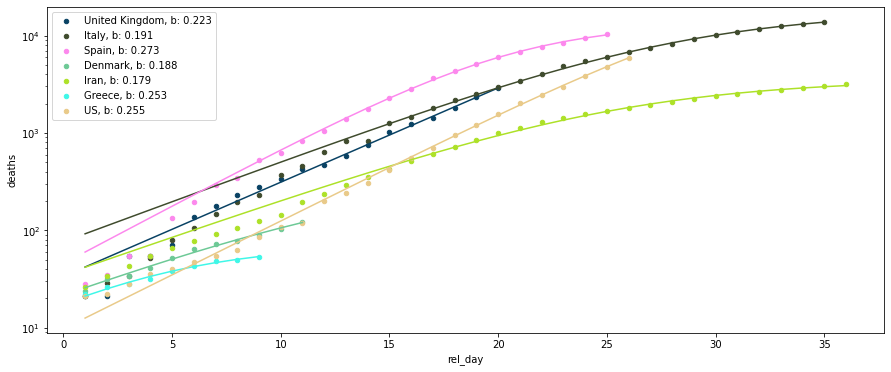

In [54]:
## Timeseries calculate  per 1M pop
def logistic_fit(x, a, b, c):
    """
    x is variable.
    a is shift along x axis
    b is steepness
    c is asymptote max
    """
    return c / (1 + a * np.exp(-b*x))

LogisticModel = Model(logistic_fit)

one_mil = 10**6
LABELS = ('cases', 'deaths', 'recoveries')
for label in LABELS:
    ts_df[label + '_per_1M'] = ts_df[label]/one_mil
ts_df

label = 'deaths'
countries = ['United Kingdom', 'Italy', 'Spain', 'Denmark', 'Iran', 'Greece', 'US']

fig, ax = plt.subplots(figsize=(15, 6))
ax.set_yscale('log')
for country in countries:
    print("Processing {}".format(country))
    col = np.random.rand(3,)
    x = find_date_of_nth_label(ts_df, country, 20, label.strip('_per_1M'))

    sub_df = ts_df[ts_df['province_state'] == country]
    rel_df = sub_df[sub_df.index.levels[1] >= x]
    rel_df['rel_day'] = rel_df['day'] - rel_df['day'].iloc[0] + 1
    # rel_df.plot.scatter(x='rel_day', y=label)

    model = LogisticModel
    params = model.make_params(c=1000, a=1000, b=0.3)
    result = model.fit(rel_df[label], params, x=rel_df['rel_day'])

    rel_df.plot.scatter(x='rel_day', y=label, c=col, ax=ax, label=country + ", b: " + str(round(result.params['b'].value, 3)))
    plt.plot(rel_df['rel_day'], result.best_fit, c=col)
    print(result.params)

plt.legend()


In [11]:
Model(logistic_fit)

<lmfit.Model: Model(logistic_fit)>

In [50]:
result.params['b'].value

0.2228364590092018

In [5]:
COVID_URL = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx'
covid_df = pd.read_excel(COVID_URL)


In [6]:
covid_df.rename(columns={'countriesAndTerritories': 'country'}, inplace=True)
covid_df.set_index(['country'], inplace=True)
covid_df

,dateRep,day,month,year,cases,deaths,geoId,countryterritoryCode,popData2018
country,,,,,,,,,
Afghanistan,2020-04-02,2,4,2020,26,0,AF,AFG,37172386.0
Afghanistan,2020-04-01,1,4,2020,25,0,AF,AFG,37172386.0
Afghanistan,2020-03-31,31,3,2020,27,0,AF,AFG,37172386.0
Afghanistan,2020-03-30,30,3,2020,8,1,AF,AFG,37172386.0
Afghanistan,2020-03-29,29,3,2020,15,1,AF,AFG,37172386.0
...,...,...,...,...,...,...,...,...,...
Zimbabwe,2020-03-25,25,3,2020,0,0,ZW,ZWE,14439018.0
Zimbabwe,2020-03-24,24,3,2020,0,1,ZW,ZWE,14439018.0
Zimbabwe,2020-03-23,23,3,2020,0,0,ZW,ZWE,14439018.0


In [7]:
covid_df.sort_values(by=['country', 'dateRep'], inplace=True)

In [8]:
covid_df['deaths_per_1M'] = covid_df.deaths/(covid_df.popData2018/(10**6))
covid_df['cases_per_1M'] = covid_df.cases/(covid_df.popData2018/(10**6))


covid_df['cum_deaths'] = covid_df.groupby(['country']).deaths.cumsum()
covid_df['cum_cases'] = covid_df.groupby(['country']).cases.cumsum()
covid_df['cum_deaths_per_1M'] = covid_df.groupby(['country']).deaths_per_1M.cumsum()
covid_df['cum_cases_per_1M'] = covid_df.groupby(['country']).cases_per_1M.cumsum()


covid_df['ln_cum_deaths'] = np.log(covid_df['cum_deaths'].replace(0, np.nan))
covid_df['ln_cum_cases'] = np.log(covid_df['cum_cases'].replace(0, np.nan))
covid_df['ln_cum_deaths_per_1M'] = np.log(covid_df['cum_deaths_per_1M'].replace(0, np.nan))
covid_df['ln_cum_cases_per_1M'] = np.log(covid_df['cum_cases_per_1M'].replace(0, np.nan))

covid_df.loc['Denmark']

,dateRep,day,month,year,cases,deaths,geoId,countryterritoryCode,popData2018,deaths_per_1M,cases_per_1M,cum_deaths,cum_cases,cum_deaths_per_1M,cum_cases_per_1M,ln_cum_deaths,ln_cum_cases,ln_cum_deaths_per_1M,ln_cum_cases_per_1M
country,,,,,,,,,,,,,,,,,,,
Denmark,2019-12-31,31,12,2019,0,0,DK,DNK,5797446.0,0.000000,0.000000,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN
Denmark,2020-01-01,1,1,2020,0,0,DK,DNK,5797446.0,0.000000,0.000000,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN
Denmark,2020-01-02,2,1,2020,0,0,DK,DNK,5797446.0,0.000000,0.000000,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN
Denmark,2020-01-03,3,1,2020,0,0,DK,DNK,5797446.0,0.000000,0.000000,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN
Denmark,2020-01-04,4,1,2020,0,0,DK,DNK,5797446.0,0.000000,0.000000,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Denmark,2020-03-29,29,3,2020,155,13,DK,DNK,5797446.0,2.242367,26.735911,65,2201,11.211834,379.649936,4.174387,7.696667,2.416970,5.939250
Denmark,2020-03-30,30,3,2020,194,7,DK,DNK,5797446.0,1.207428,33.463011,72,2395,12.419262,413.112947,4.276666,7.781139,2.519249,6.023721
Denmark,2020-03-31,31,3,2020,182,5,DK,DNK,5797446.0,0.862449,31.393134,77,2577,13.281711,444.506081,4.343805,7.854381,2.586388,6.096964


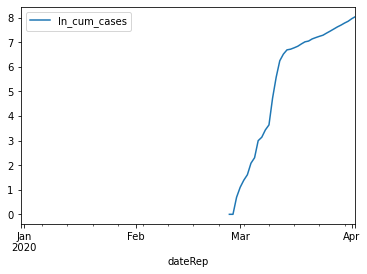

In [9]:
covid_df.loc['Denmark'].plot(x='dateRep', y='ln_cum_cases')

In [10]:
# Find number of cases per 1M pop after X days of first case
days_since_1st_case = 30

covid_df = covid_df.reset_index().set_index(['country'])
x_covid_df = covid_df.reset_index().set_index(['country', 'dateRep'])

covid_df['time_first_case'] = x_covid_df.groupby('country')['cases'].apply(lambda x: x.ne(0).idxmax()[1])
covid_df['days_since_first_case'] = (covid_df['dateRep'] - covid_df['time_first_case']).dt.days
covid_df['time_x_case'] = covid_df['time_first_case'] + datetime.timedelta(days=days_since_1st_case)

del x_covid_df
covid_df

,dateRep,day,month,year,cases,deaths,geoId,countryterritoryCode,popData2018,deaths_per_1M,...,cum_cases,cum_deaths_per_1M,cum_cases_per_1M,ln_cum_deaths,ln_cum_cases,ln_cum_deaths_per_1M,ln_cum_cases_per_1M,time_first_case,days_since_first_case,time_x_case
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2019-12-31,31,12,2019,0,0,AF,AFG,37172386.0,0.0,...,0,0.000000,0.000000,NaN,NaN,NaN,NaN,2020-02-25,-56,2020-03-26
Afghanistan,2020-01-01,1,1,2020,0,0,AF,AFG,37172386.0,0.0,...,0,0.000000,0.000000,NaN,NaN,NaN,NaN,2020-02-25,-55,2020-03-26
Afghanistan,2020-01-02,2,1,2020,0,0,AF,AFG,37172386.0,0.0,...,0,0.000000,0.000000,NaN,NaN,NaN,NaN,2020-02-25,-54,2020-03-26
Afghanistan,2020-01-03,3,1,2020,0,0,AF,AFG,37172386.0,0.0,...,0,0.000000,0.000000,NaN,NaN,NaN,NaN,2020-02-25,-53,2020-03-26
Afghanistan,2020-01-04,4,1,2020,0,0,AF,AFG,37172386.0,0.0,...,0,0.000000,0.000000,NaN,NaN,NaN,NaN,2020-02-25,-52,2020-03-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe,2020-03-29,29,3,2020,2,0,ZW,ZWE,14439018.0,0.0,...,7,0.069257,0.484798,0.0,1.945910,-2.669934,-0.724024,2020-03-21,8,2020-04-20
Zimbabwe,2020-03-30,30,3,2020,0,0,ZW,ZWE,14439018.0,0.0,...,7,0.069257,0.484798,0.0,1.945910,-2.669934,-0.724024,2020-03-21,9,2020-04-20
Zimbabwe,2020-03-31,31,3,2020,0,0,ZW,ZWE,14439018.0,0.0,...,7,0.069257,0.484798,0.0,1.945910,-2.669934,-0.724024,2020-03-21,10,2020-04-20


country                              days_since_first_case  \
0   Spain  country
Spain     2
Spain     3
Spain     4
Sp...   

                                                   y          fit_a    fit_b  \
0  country
Spain         1
Spain         1
Spain ...  554671.446714  0.22824   

          fit_c                                            fit_cov  
0  141511.73265  [[5840280238.292282, 223.78050785551463, -1520...  


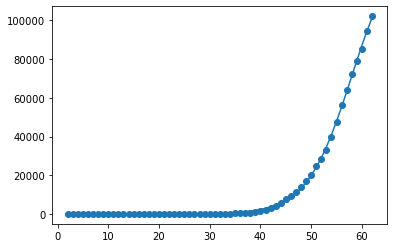

In [11]:
def logistic_fit(t, a, b, c):
    """
    t is variable.
    a is shift along x axis
    b is steepness
    c is asymptote max
    """
    return c / (1 + a * np.exp(-b*t))

p0 = np.random.exponential(size=3)
bounds = (0, [1000000., 3., 1000000000])

def logistic_fit_country(country, c_df, maxfev=10000, y_label='cum_cases'):
    active_df = c_df.loc[[country]]
    active_df = active_df[active_df['days_since_first_case'] > 0]

    x = active_df.loc[[country]]['days_since_first_case'] + 1
    y = active_df.loc[[country]][y_label]

    (a,b,c), cov = curve_fit(logistic_fit, x, y, bounds=bounds, p0=p0, maxfev=maxfev)
    
    r_df = pd.DataFrame(columns=['country', 'days_since_first_case', 'y', 'fit_a', 'fit_b', 'fit_c', 'fit_cov'])
    r_df.loc[0] = [country, x, y, a, b, c, cov]
    
    return r_df



country = "Spain"

active_df = covid_df.loc[country]
active_df = active_df[active_df['days_since_first_case'] > 0]

x = active_df.loc[country]['days_since_first_case'] + 1
y = active_df.loc[country]['cum_cases']

(a,b,c), cov = curve_fit(logistic_fit, x, y, bounds=bounds, p0=p0, maxfev=5000)

print(logistic_fit_country(country, covid_df))

plt.scatter(x,y)
plt.plot(x, logistic_fit(x, a, b, c))